In [1701]:
from pandas import DataFrame,read_csv,concat
from numpy import argmax,cumsum
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber


from joblib import dump

##### Read the data

In [1702]:
salary_data = read_csv('content/salary.csv')

null_indices = salary_data[salary_data.isnull().any(axis=1)].index.tolist()
print("Null values indices:", null_indices)

salary_data.shape


Null values indices: [172, 260]


(375, 6)

In [1703]:
salary_data = salary_data.drop(index=null_indices,axis=1)
salary_data

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


##### Created a seperate salary data

In [1704]:

target_salary_data = salary_data['Salary']
salary_data = salary_data.drop(columns=['Salary'],axis=1)

target_salary_data


0       90000.0
1       65000.0
2      150000.0
3       60000.0
4      200000.0
         ...   
370     85000.0
371    170000.0
372     40000.0
373     90000.0
374    150000.0
Name: Salary, Length: 373, dtype: float64

In [ ]:

scaler = MinMaxScaler()
target_salary_data = scaler.fit_transform(target_salary_data.values.reshape(-1, 1))

dump(scaler, 'arget_salary_scaler.pkl')




In [1706]:

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False,dtype='int')

encoded_cols = ["Age", "Education Level", "Job Title","Gender"]
encoder.fit(salary_data[encoded_cols])


encoded_data = encoder.transform(salary_data[encoded_cols])
encoded_df = DataFrame(encoded_data, columns=encoder.get_feature_names_out(encoded_cols),dtype=int)

encoded_df = encoded_df.astype(int)

salary_data = concat([
    salary_data.drop(columns=encoded_cols).reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)
dump(encoder, 'encoder.pkl')

encoder.categories_

[array([23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
        36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
        49., 50., 51., 52., 53.]),
 array(["Bachelor's", "Master's", 'PhD'], dtype=object),
 array(['Account Manager', 'Accountant', 'Administrative Assistant',
        'Business Analyst', 'Business Development Manager',
        'Business Intelligence Analyst', 'CEO', 'Chief Data Officer',
        'Chief Technology Officer', 'Content Marketing Manager',
        'Copywriter', 'Creative Director', 'Customer Service Manager',
        'Customer Service Rep', 'Customer Service Representative',
        'Customer Success Manager', 'Customer Success Rep', 'Data Analyst',
        'Data Entry Clerk', 'Data Scientist', 'Digital Content Producer',
        'Digital Marketing Manager', 'Director',
        'Director of Business Development', 'Director of Engineering',
        'Director of Finance', 'Director of HR',
        'Director of Human Capital', 'Dir

In [1707]:
scaler_pca = MinMaxScaler()
salary_data = scaler_pca.fit_transform(salary_data.values)
salary_data

array([[0.2 , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.12, 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.6 , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       ...,
       [0.08, 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.28, 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.6 , 0.  , 0.  , ..., 0.  , 1.  , 0.  ]])

In [1708]:
train_salary_data, test_salary_data,train_target_salary_data,test_target_salary_data = train_test_split(salary_data, target_salary_data, test_size=0.2, random_state=42)

In [1709]:
pca = PCA(n_components=211)

pca.fit(train_salary_data)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = cumsum(explained_variance_ratio)
optimal_k = argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components (k) for 95% variance: {optimal_k}")
pca = PCA(n_components=optimal_k)
pca_train_salary_data = pca.fit_transform(train_salary_data)
pca_train_salary_data.shape

dump(pca, 'pca_model.pkl')


Optimal number of components (k) for 95% variance: 118


['pca_model.pkl']

/var/folders/zw/wpbmbv6s62vc85qfn9szsqgm0000gn/T/ipykernel_77480/2897067571.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(
/var/folders/zw/wpbmbv6s62vc85qfn9szsqgm0000gn/T/ipykernel_77480/2897067571.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


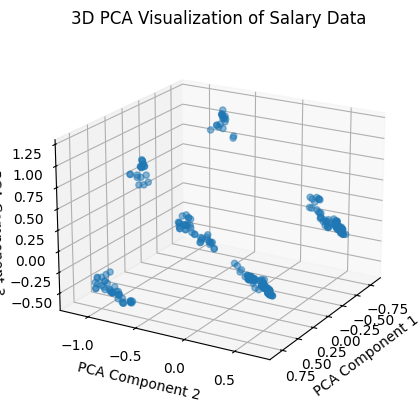

In [1710]:
from seaborn import scatterplot
from matplotlib.pyplot import figure, show

fig = figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    pca_train_salary_data[:, 0],
    pca_train_salary_data[:, 1],
    pca_train_salary_data[:, 2],
    cmap='viridis',
    alpha=0.5
)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of Salary Data')
ax.view_init(elev=20, azim=30)
fig.show()




In [1711]:
model = Sequential(
    [
        Dense(147, input_shape=(pca_train_salary_data.shape[1],),activation = "relu"),
        Dense(45, activation="relu"),
        Dense(6, activation="relu"),
        Dense(1, activation="relu"),
    ]
)

/Users/fastasturtle/Documents/MTech/Assignment/ML/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [1712]:
model.compile(loss = Huber(delta=0.05), optimizer="adam", metrics=["mean_absolute_error"])

In [1713]:
model.summary()

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_377 (Dense)               │ (None, 147)            │        17,493 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 45)             │         6,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 6)              │           276 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,436 (95.45 KB)

 Trainable params: 24,436 (95.45 KB)

 Non-trainable params: 0 (0.00 B)

In [1714]:
train_salary_data.shape

(298, 211)

In [1715]:
history = model.fit(pca_train_salary_data, train_target_salary_data,  epochs=100, validation_split=0.1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0150 - mean_absolute_error: 0.3243 - val_loss: 0.0073 - val_mean_absolute_error: 0.1691
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.1407 - val_loss: 0.0051 - val_mean_absolute_error: 0.1246
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.1104 - val_loss: 0.0029 - val_mean_absolute_error: 0.0804
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0744 - val_loss: 0.0019 - val_mean_absolute_error: 0.0588
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0554 - val_loss: 0.0015 - val_mean_absolute_error: 0.0493
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0401 - val_loss: 0.0013 - val_mean_absolute_error: 0.0448
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2772e-04 - mean_absolute_error: 0.0312 - val_loss: 0.0011 

In [1716]:
test_salary_data

array([[0.84, 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.4 , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.64, 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       ...,
       [0.16, 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.56, 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.32, 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

In [1717]:
pca_test_salary_data = pca.transform(test_salary_data)
pca_test_salary_data

array([[-6.10283401e-01, -1.09456830e+00, -4.01539715e-01, ...,
        -5.03949351e-16,  1.86730060e-16, -3.60216960e-16],
       [ 6.99799433e-01,  5.19275508e-01,  1.74257777e-02, ...,
         2.49030177e-16, -1.99095842e-16, -6.81000151e-17],
       [-7.05997891e-01,  2.87194198e-01,  2.55174404e-01, ...,
         5.32503333e-17,  2.93518438e-16,  2.17727820e-16],
       ...,
       [-8.17192330e-01,  5.05667748e-01, -1.28053683e-01, ...,
         3.36562200e-17,  1.39834394e-17, -7.79075898e-17],
       [ 7.79551638e-01, -8.85003767e-01, -2.68459867e-01, ...,
         1.97862568e-02,  4.02691245e-02,  7.01232948e-03],
       [-7.71550002e-01,  4.58363526e-01, -2.26514493e-02, ...,
         5.21844427e-17,  2.98595418e-17,  9.92507443e-17]])

In [1718]:
model.evaluate(pca_test_salary_data, test_target_salary_data, verbose=2)

3/3 - 0s - 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0516


[0.0016837966395542026, 0.05160801112651825]

In [1719]:
predictions = model.predict(pca_test_salary_data)
unscaled_predictions = scaler.inverse_transform(predictions)
unscaled_test_target_salary_data = scaler.inverse_transform(test_target_salary_data)
unscaled_predictions[:10], unscaled_test_target_salary_data[:10]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


(array([[187844.72 ],
        [ 70788.234],
        [111775.91 ],
        [107027.19 ],
        [126285.22 ],
        [160318.17 ],
        [119779.27 ],
        [113092.96 ],
        [ 61716.316],
        [104269.93 ]], dtype=float32),
 array([[180000.],
        [ 65000.],
        [125000.],
        [ 80000.],
        [140000.],
        [160000.],
        [160000.],
        [120000.],
        [ 50000.],
        [ 95000.]]))

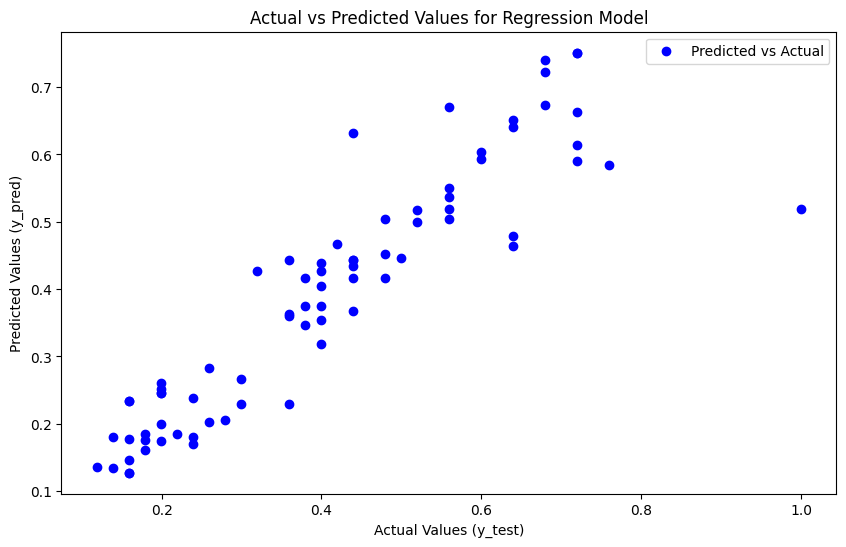

In [1720]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test_target_salary_data, predictions, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values for Regression Model')
plt.legend()
plt.show()

In [1721]:
from keras import ops


In [1722]:
model.save('salary_model.keras')